# Building the Ensemble Model

### Packages

In [1]:
### Data Handling & Helpers
import pandas as pd
import numpy as np
import pandas_ta as ta

### Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

### Processing
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

### Models
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

### Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

### Function Space

In [105]:
# Pie chart
def pie_chart(dataset, **kwargs):
    labels = '-1', '1', '0'
    sizes = [(len(dataset[dataset==-1])/len(dataset)), 
             (len(dataset[dataset==1])/len(dataset)), 
             (len(dataset[dataset==0])/len(dataset))]

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
    ax1.axis('equal')
    if "title" in kwargs: ax1.set_title(kwargs["title"])
    plt.show()

# Method for Creating past data as Xtraini and Xtest as recent data
def create_timeseries_split(dataframe, test_size):
    stop = int(len(dataframe) * (1-test_size));
    
    Train =  dataframe.iloc[0:stop]
    Test = dataframe.iloc[stop+1:-1]

    Xtrain = Train.drop(columns="Target")
    ytrain = Train.Target

    Xtest = Test.drop(columns="Target")
    ytest = Test.Target
    
    return Xtrain, Xtest, ytrain, ytest

# Sklearn method for creating training and test data sets
def create_splits(X, y, rnd_state=2, test_size=0.30):
    return train_test_split(X, y, test_size=test_size, random_state=rnd_state)

def target_helper(y_pred, y_testp, SP500, test_size):
    SP500.ta.ema(length = 30, append=True)
    SP500["EMA_30_FT"] = SP500.EMA_30.shift(periods=-30)
    SP500["Diff"] = (SP500.EMA_30_FT - SP500.EMA_30)
    SP500["Diff_ratio"] = SP500.Diff / SP500.EMA_30
    SP500["Diff_shift"] = SP500.Diff_ratio.shift(periods=-30)
    SP500["Target"] = SP500.Diff_shift.apply(lambda x: -1 if x < -0.01 else (1 if x > 0.01 else 0))
    SP500["Pred"] = y_pred
    return SP500

### Import the Data

In [3]:
dataframe = pd.read_csv(r"data/momentum_market_data.csv", index_col="Date")
# dataframe.head(5)

### Process the Data
As expected there are not issues with the dataset. No multi-colinearity so the models should do fine. All values are oscillators so finding boundaries should be easier for the models. 

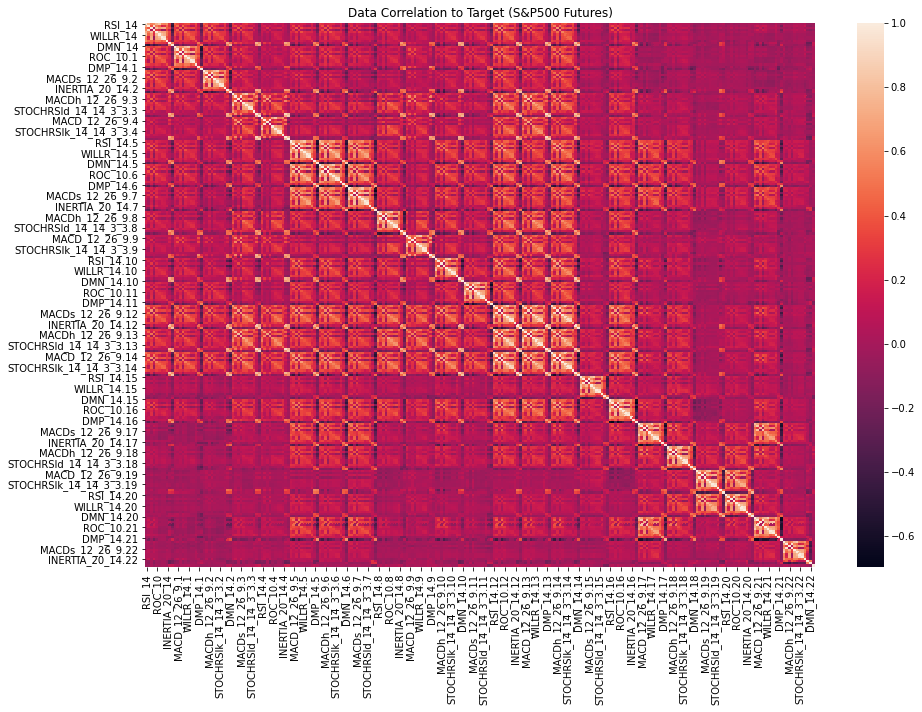

In [4]:
plt.figure(figsize=(15,10))
sns.heatmap(dataframe.corr())
plt.xlabel('')
plt.ylabel('')
plt.title('Data Correlation to Target (S&P500 Futures)')
fig.savefig(r"figures\DataCorrelationPlot.png", dpi=600)
plt.show()

Here I'm making 3 sets of data. One for training the model, another for testing the model, and another for testing the model predictions in a forward intime capacity. _Note: I'm not certain this is the most efficient way to achieve high performance._ 

In [24]:
train_and_test = create_timeseries_split(dataframe, test_size=0.10) 
Xtrain =train_and_test[0].to_numpy() 
Xtest_ft =train_and_test[1].to_numpy()
ytrain = train_and_test[2].to_numpy()
ytest_ft = train_and_test[3].to_numpy()
X_train, X_test, y_train, y_test = create_splits(Xtrain, ytrain)

print(f'Training sample: [{X_train.shape}, {y_train.shape}], ({type(X_train)}, {type(X_train)})')
print(f'Train Test sample: [{X_test.shape}, {y_test.shape}], ({type(X_test)}, {type(X_test)})')
print(f'Test sample: [{Xtest_ft.shape}, {ytest_ft.shape}], ({type(Xtest_ft)}, {type(Xtest_ft)})')

Training sample: [(2910, 253), (2910,)], (<class 'numpy.ndarray'>, <class 'numpy.ndarray'>)
Train Test sample: [(1248, 253), (1248,)], (<class 'numpy.ndarray'>, <class 'numpy.ndarray'>)
Test sample: [(460, 253), (460,)], (<class 'numpy.ndarray'>, <class 'numpy.ndarray'>)


---
## Gathering the Models
- Running Grid-Search again, because the dataset is much larger now, and the models might prefer some differently tuned hyperparameters. 
- Gathering the best estimators and using those into the ensemble
- Using a soft voting class ensemble to generate final target

#### Support Vector Machine Classifier (SVC)

In [6]:
svm_m = modeling_pipeline = Pipeline([('scaling', StandardScaler()), 
                                      ('pca', PCA()),
                                      ('model', SVC()), 
                                      ])

param_grid = [{'model__C': [1, 10, 100, 1000], 
               'pca__n_components': [None,1,5,10,15], 
               'model__kernel': ['rbf'], 
               'model__probability':[True]
              }]

scoring = ['f1_macro', 'roc_auc_ovo']

svm_results = GridSearchCV(estimator=svm_m, param_grid=param_grid, scoring=scoring, refit='roc_auc_ovo', cv=5, n_jobs=-1)
svm_results = svm_results.fit(X_train, y_train)

In [7]:
# svm_score = svm_results.best_score_
print(f'Support Vector Machine Score: {svm_results.best_score_:.2%}')
print(svm_results.best_estimator_, svm_results.best_params_)
svm = svm_results.best_estimator_

Support Vector Machine Score: 98.94%
Pipeline(steps=[('scaling', StandardScaler()), ('pca', PCA()),
                ('model', SVC(C=10, probability=True))]) {'model__C': 10, 'model__kernel': 'rbf', 'model__probability': True, 'pca__n_components': None}


In [8]:
from sklearn.metrics import classification_report
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.97      0.95      0.96       312
         0.0       0.90      0.91      0.91       253
         1.0       0.98      0.99      0.98       683

    accuracy                           0.96      1248
   macro avg       0.95      0.95      0.95      1248
weighted avg       0.96      0.96      0.96      1248



#### K-Nearest Neighbors (KNN)

In [9]:
knn_m = modeling_pipeline = Pipeline([('scaling', StandardScaler()),
                                      ('pca', PCA(n_components=None)),
                                      ('model', KNeighborsClassifier())])


param_grid = [
  {'model__n_neighbors': [1, 4, 8, 10, 15], 
   'pca__n_components': [None,1,2,3,4,5,10,15],
   'model__weights': ['uniform','distance']}
 ]

knn_results = GridSearchCV(estimator=knn_m, param_grid=param_grid, scoring=scoring, refit='roc_auc_ovo', cv=5, n_jobs=-1)
knn_results = knn_results.fit(X_train, y_train)

In [10]:
knn_score = knn_results.score(X_test, y_test)
print(f'k-Nearest Neighbor Score: {knn_score:.2%}')
print(knn_results.best_estimator_)

k-Nearest Neighbor Score: 99.32%
Pipeline(steps=[('scaling', StandardScaler()), ('pca', PCA()),
                ('model',
                 KNeighborsClassifier(n_neighbors=4, weights='distance'))])


In [107]:
from sklearn.metrics import classification_report
y_pred = knn_results.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.96      0.95      0.96       312
         0.0       0.87      0.90      0.88       253
         1.0       0.98      0.98      0.98       683

    accuracy                           0.95      1248
   macro avg       0.94      0.94      0.94      1248
weighted avg       0.95      0.95      0.95      1248



#### Random Forest (RF)

In [11]:
rf_pipeline = Pipeline([('scaling', StandardScaler()),
                        ('pca', PCA(n_components=None)),
                        ('rf', RandomForestClassifier())
                       ])

param_grid = [{'rf__max_depth': [10, 15, 20],
               'rf__n_estimators': [25, 50, 100],
               'rf__class_weight': [None, 'balanced', 'balanced_subsample'],
               'pca__n_components': [None,10,15,20]
              }]

rf_results = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, scoring=scoring, refit='roc_auc_ovo', cv=5, n_jobs=-1)
rf_results = rf_results.fit(X_train, y_train)
rf_yhat = rf_results.predict(X_test)

rf_results.best_estimator_

Pipeline(steps=[('scaling', StandardScaler()), ('pca', PCA(n_components=20)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=20))])

In [12]:
y_testp = rf_results.predict(X_test)
y_testp_rf = rf_results.predict_proba(X_test)


print(f'Validation score: {rf_results.best_score_:.2%}')
print(f'Test score: {rf_results.score(X_test, y_test):.2%}')


from sklearn.metrics import classification_report
print(classification_report(y_test, y_testp))

Validation score: 96.49%
Test score: 98.13%
              precision    recall  f1-score   support

        -1.0       0.97      0.86      0.91       312
         0.0       0.91      0.68      0.78       253
         1.0       0.86      0.99      0.92       683

    accuracy                           0.89      1248
   macro avg       0.91      0.84      0.87      1248
weighted avg       0.90      0.89      0.89      1248



These are excellent scores. To my knowledge, no target data has been leaked into the training set. I believe this is diractly related to the ticker symbols I've chosen to include. 
Notes: 
- The SVM did better with no PCA while the Random Forest best estimator used a 20 componet PCA. This is probably because of model methods. The RF is constantly splitting data, limiting the data to several components and a tree depth of 20 mostlikely made the weak estimatator forest stronger a whole. Also this RF is uses more data than the previosly pilot tested version in the ChooseModels file, where the RF best estimator use a PCA of 15 and max depth of 15 here both are 20. 
- As expected the KNN model is the best estimator over all with a 99% score. What is not expected is that the neighboring range is set to 4 whereas in the pilot test it was set to 1. This means that the large dataset is better understood when grouping by 4s with distance. 

#### Voting Classifier Ensemble 

In [13]:
ems = [('knn', knn_results.best_estimator_),('rf', rf_results.best_estimator_),('svm', svm_results.best_estimator_)]
en = VotingClassifier(estimators=ems, weights=None, voting='soft', n_jobs=-1)
en = en.fit(X_train, y_train)
scores = cross_val_score(estimator=en, X=X_train, y=y_train, cv=10, scoring='roc_auc_ovo')
print(f'ROC AUC OVO {scores.mean():.2f} (+/- {scores.std():.2f}) [Ensemble]')

ROC AUC OVO 0.99 (+/- 0.01) [Ensemble]


In [14]:
y_testp = en.predict(X_test)
y_testp_en = en.predict_proba(X_test)

print(f'Test score: {en.score(X_test, y_test):.2%}')

from sklearn.metrics import classification_report
print(classification_report(y_test, y_testp))

Test score: 96.15%
              precision    recall  f1-score   support

        -1.0       0.97      0.96      0.96       312
         0.0       0.91      0.90      0.90       253
         1.0       0.98      0.99      0.98       683

    accuracy                           0.96      1248
   macro avg       0.95      0.95      0.95      1248
weighted avg       0.96      0.96      0.96      1248



In [15]:
ytestp = en.predict(Xtest_ft)
ytestp_en = en.predict_proba(Xtest_ft)

print(f'Test score: {en.score(Xtest_ft, ytest_ft):.2%}')

from sklearn.metrics import classification_report
print(classification_report(ytest_ft, ytestp))

Test score: 62.61%
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        33
         0.0       0.00      0.00      0.00        88
         1.0       0.79      0.85      0.82       339

    accuracy                           0.63       460
   macro avg       0.26      0.28      0.27       460
weighted avg       0.58      0.63      0.60       460



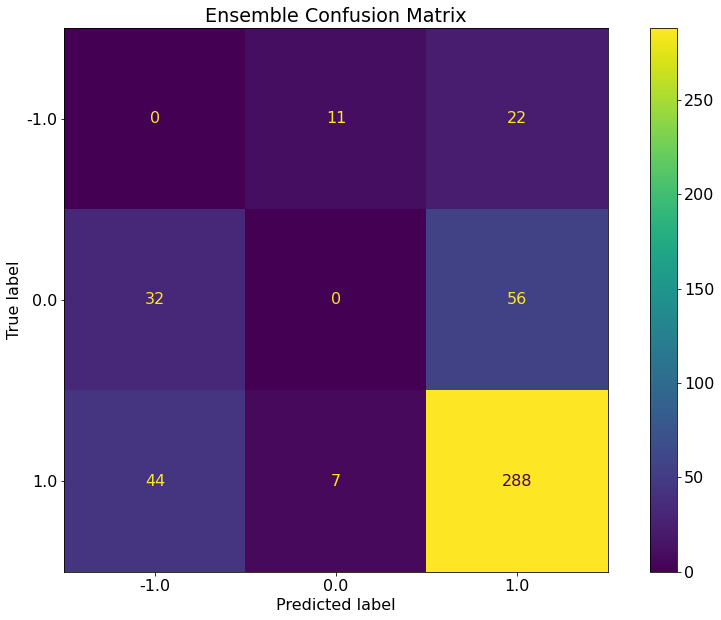

In [100]:
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest_ft, ytestp)

fig, ax = plt.subplots(figsize=(15,10))
# ax.subtitle("Best Estimator Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, 
                              display_labels=svm_results.best_estimator_.named_steps['model'].classes_)
disp.plot(ax=ax)
ax.set_title("Ensemble Confusion Matrix")
fig.savefig(r"figures\EnsembleConfusionMatrix.png", dpi=600)
plt.show()

Seems pretty good at predicting that the market will go up. 

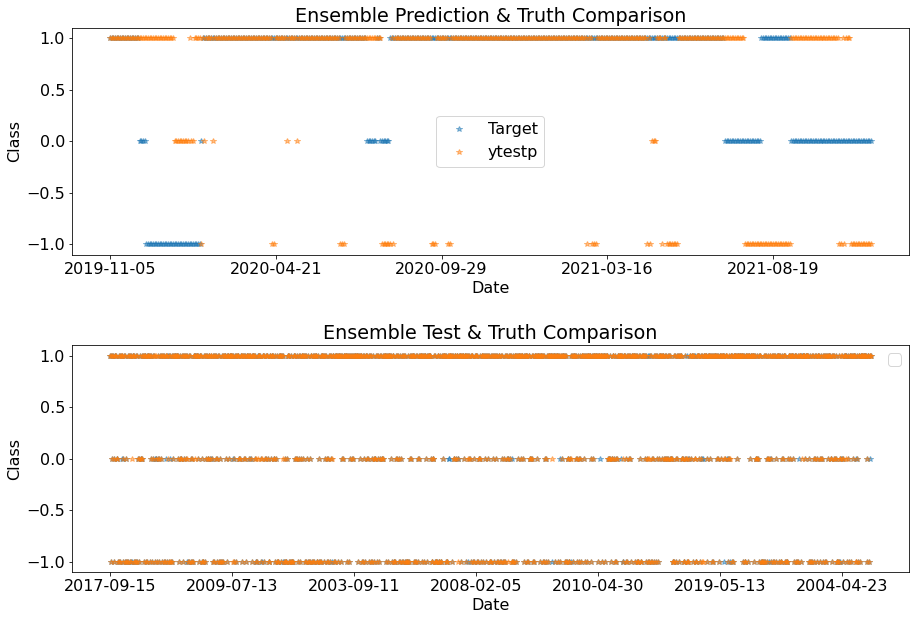

In [109]:
# Xtrain, Xtest, ytrain, ytest
X_train, X_test, y_train, y_test = create_splits(train_and_test[0], train_and_test[2])

yTEST = train_and_test[3]
yTEST = pd.concat([yTEST, pd.Series(ytestp, name="ytestp", index=yTEST.index)], axis=1)
yTRAIN = pd.concat([y_test, pd.Series(y_testp, name="y_testp", index=y_test.index)], axis=1)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
yTEST.plot(ax=ax1, style="*", alpha=.5, label="Test Data", fontsize=16)
yTRAIN.plot(ax=ax2, style="*", alpha=.5, label="Training Test Data", fontsize=16)
ax1.legend()
ax2.legend("")
ax1.set_title("Ensemble Prediction & Truth Comparison")
ax2.set_title("Ensemble Test & Truth Comparison")
ax1.set_ylabel("Class")
ax2.set_ylabel("Class")
plt.subplots_adjust(hspace=0.4)
fig.savefig(r"figures\EnsemblePredictionComparison.png", dpi=600)

---
## Next Steps!!!
- Needs more tuning...
- Needs another thorough look through...
- Conversion into something deployable
- Train for 14-Day and 7-Day forecasts